In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from data_providers.price_history_sliding_window_data_provider \
    import PriceHistorySlidingWindowDataProvider
from models.model_09_price_history_rnn_sliding_window import PriceHistoryRnnSlidingWindow
from cost_functions.huber_loss import huber_loss
from os.path import isdir

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

In [4]:
from common import get_or_run_nn
data_folder = '../../../../Dropbox/data'
assert isdir(data_folder)

### Step 0 - hyperparams

In [5]:
num_epochs = 10

num_features = 1
state_size = 400
input_len = 60
target_len = 30
batch_size = 47

pred_len = 1
trunc_backprop_len = 60

### Step 1 - collect data (and/or generate them)

In [6]:
#csv_in = '../price_history_03a_fixed_width.csv'
npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'

In [7]:
# XX, YY, sequence_lens, seq_mask = PriceHistoryGenerator.createAndSaveDataset(
#     csv_in=csv_in,
#     npz_out=npz_path,
#     input_seq_len=60, target_seq_len=30)
# XX.shape, YY.shape, sequence_lens.shape, seq_mask.shape

In [8]:
dp = PriceHistorySlidingWindowDataProvider(npz_path=npz_path, batch_size=batch_size,
                                          trunc_backprop_len=trunc_backprop_len, pred_len = pred_len)
dp.inputs.shape, dp.targets.shape

((11374, 60, 1), (11374, 30))

In [9]:
dummy = -np.random.randn(47,pred_len, 1)
print dummy.shape

aa, bb, cc, dd, ee = dp.next()
dp.stackPreds(new_preds=dummy)
print aa.shape, bb.shape, cc, dd, ee.T
aa[1].T

(47, 1, 1)
(47, 60, 1) (47, 1, 1) False 1 [[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
    1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
    1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]]


array([[ 0.  , -0.45, -0.55, -0.7 , -1.1 , -1.55, -2.05, -2.4 , -2.75,
        -3.15, -2.45, -2.2 , -2.6 , -3.05, -3.5 , -3.85, -4.25, -3.45,
        -3.55, -4.  , -4.35, -4.85, -5.25, -5.7 , -6.96, -7.96, -5.39,
        -1.55, -0.97, -1.56, -1.55, -2.4 , -2.8 , -2.95, -2.95, -2.06,
        -2.06, -1.86, -1.38, -0.55, -1.61, -0.55, -0.55,  1.05, -0.55,
         1.35,  1.44,  1.35,  1.44,  4.  ,  0.45,  3.86,  3.5 ,  3.  ,
         2.55, -1.61, -1.61,  2.3 ,  2.25,  1.5 ]])

In [10]:
graph = tf.Graph()

with graph.as_default():
    count_inc_losses = tf.constant(0, dtype=tf.int32)
    losses = tf.constant(bb, dtype=dtype)
    
    size_shape = list(losses.get_shape())
    begin_shape = list(np.zeros(len(size_shape)).astype(np.int))
    size_shape = (size_shape[0].value, count_inc_losses, size_shape[2].value)
    begin_shape = (begin_shape[0], pred_len - count_inc_losses, begin_shape[2])
    
    print begin_shape
    print size_shape
    
    
    sliced = tf.slice(losses, begin_shape, size_shape)
    
with tf.Session(graph=graph) as sess:
    print sess.run(sliced).shape

(0, <tf.Tensor 'sub:0' shape=() dtype=int32>, 0)
(47, <tf.Tensor 'Const:0' shape=() dtype=int32>, 1)
(47, 0, 1)


### Step 2 - Build model

In [11]:
model = PriceHistoryRnnSlidingWindow(rng=random_state, dtype=dtype, config=config)

In [12]:
graph = model.getGraph(batch_size=batch_size,
                       state_size=state_size,
                       pred_len=pred_len,
                       trunc_backprop_len=trunc_backprop_len)

learning rate: 0.001000
60
Tensor("inputs/unstack:0", shape=(47, 1), dtype=float32)

60
Tensor("rnn_layer/rnn/basic_rnn_cell/Tanh:0", shape=(47, 400), dtype=float32)

Tensor("readout_layer/add:0", shape=(47, 1), dtype=float32)

Tensor("predictions/stack:0", shape=(47, 1, 1), dtype=float32)

Tensor("error/Select:0", shape=(47, 1, 1), dtype=float32)

Tensor("error/Mean_1:0", shape=(), dtype=float32)



In [13]:
show_graph(graph)

### Step 3 training the network

## Basic RNN cell

In [14]:
rnn_cell = PriceHistoryRnnSlidingWindow.RNN_CELLS.BASIC_RNN
num_epochs = 36
num_epochs, state_size, batch_size

(36, 400, 47)

In [15]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        trunc_backprop_len=trunc_backprop_len,
        batch_size=batch_size,
        rnn_cell=rnn_cell,
        state_size=state_size,
        pred_len=pred_len
    )

In [16]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='003_rnn_slidewin_60to1',
                                     nn_runs_folder= data_folder + '/nn_runs')

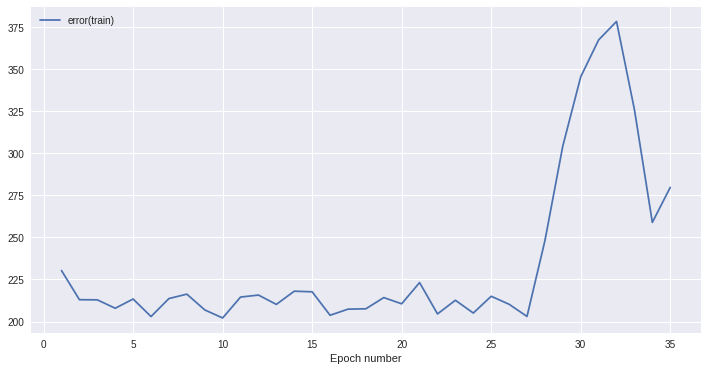

In [17]:
dyn_stats.plotStats()
plt.show()

In [18]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [19]:
ind = np.argmin(r2_scores)
ind

3918

In [20]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [21]:
r2_score(y_true=reals, y_pred=preds)

-6.2422070187998853e+31

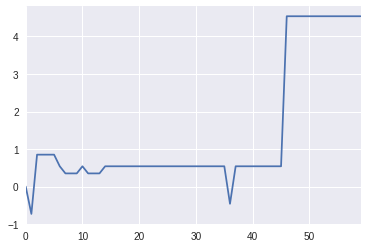

In [22]:
sns.tsplot(data=dp.inputs[ind].flatten())

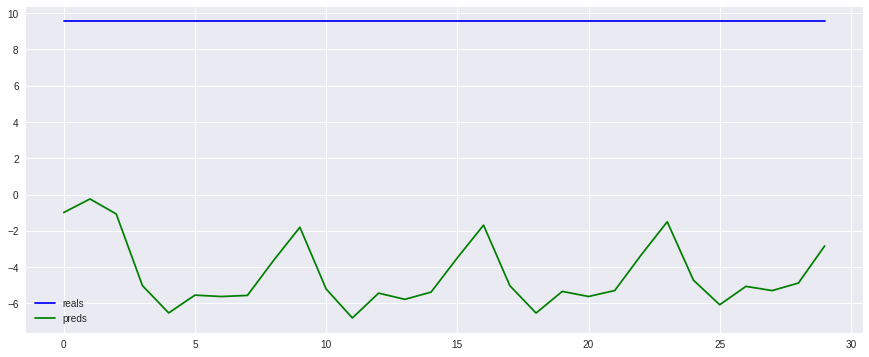

In [23]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [24]:
# %%time
# dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
#              for ind in range(len(dp.targets))]

CPU times: user 1min 13s, sys: 540 ms, total: 1min 14s
Wall time: 1min 13s


In [33]:
#np.mean(dtw_scores)
272.3528551332796

272.3528551332796

272.3528551332796

In [26]:
coint(preds, reals)

(-1.491662795061667,
 0.76437513349021091,
 array([-4.31395736, -3.55493606, -3.19393252]))

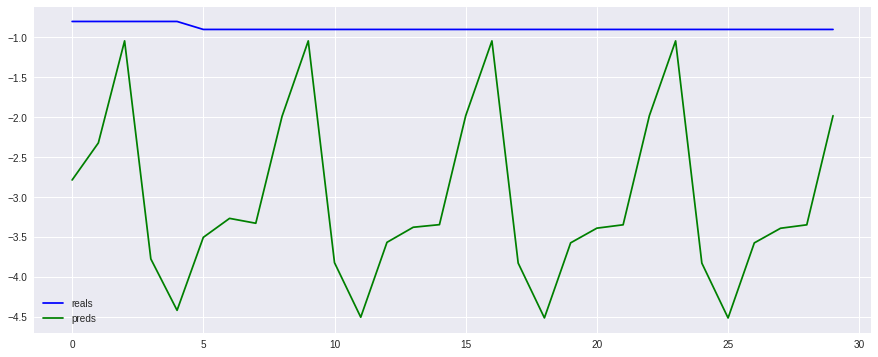

In [27]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [28]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

9.1509564221411939

### Conclusion
???

## Persistence Model Forecast - one way to create a baseline
http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/  
The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

## GRU cell

In [29]:
rnn_cell = PriceHistoryRnnSlidingWindow.RNN_CELLS.GRU
num_epochs = 36
num_epochs, state_size, batch_size

(36, 400, 47)

In [30]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        trunc_backprop_len=trunc_backprop_len,
        batch_size=batch_size,
        rnn_cell=rnn_cell,
        state_size=state_size,
        pred_len=pred_len
    )

In [31]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='003_rnn_slidewin_gru_60to1',
                                     nn_runs_folder= data_folder + '/nn_runs')

In [32]:
from matplotlib import ticker

NameError: name 'ax' is not defined

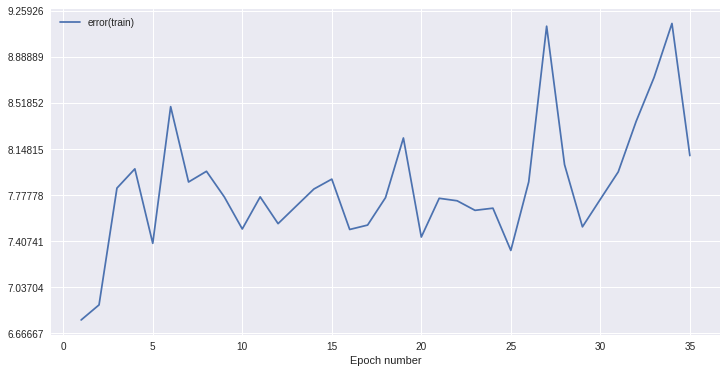

In [41]:
figs, axes = dyn_stats.plotStats()

ax = axes[0]
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/27))
ax.yaxis.set_major_formatter(ticks)

plt.show()

In [33]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [34]:
ind = np.argmin(r2_scores)
ind

3918

In [35]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [36]:
r2_score(y_true=reals, y_pred=preds)

-5.1873927523196317e+31

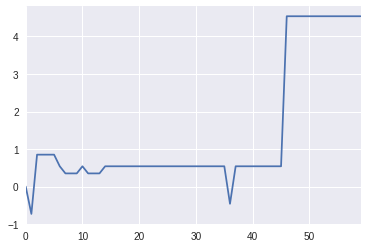

In [37]:
sns.tsplot(data=dp.inputs[ind].flatten())

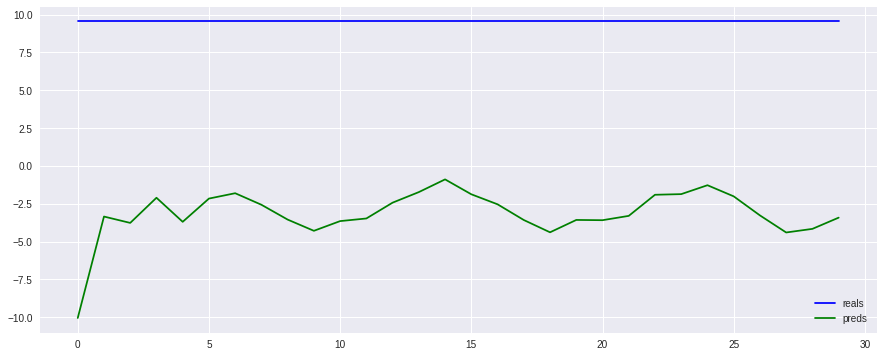

In [38]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [39]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 1min 10s, sys: 532 ms, total: 1min 11s
Wall time: 1min 10s


In [40]:
np.mean(dtw_scores)

258.45237553979763

In [41]:
coint(preds, reals)

(-0.096004059841015107,
 0.98340331539625092,
 array([-4.31395736, -3.55493606, -3.19393252]))

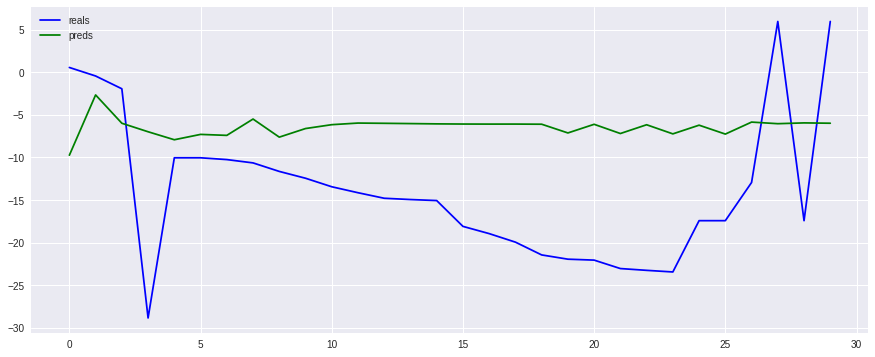

In [42]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [43]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

8.3365558151385635

## GRU cell - 100 epochs

In [44]:
rnn_cell = PriceHistoryRnnSlidingWindow.RNN_CELLS.GRU
num_epochs = 100
num_epochs, state_size, batch_size

(100, 400, 47)

In [45]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        trunc_backprop_len=trunc_backprop_len,
        batch_size=batch_size,
        rnn_cell=rnn_cell,
        state_size=state_size,
        pred_len=pred_len
    )

In [46]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='003_rnn_slidewin_gru_60to1_100epochs',
                                     nn_runs_folder= data_folder + '/nn_runs')

epochs: 100
End Epoch 01 (951.842 secs): err(train) = 180.0272
End Epoch 02 (953.513 secs): err(train) = 194.0406
End Epoch 03 (953.410 secs): err(train) = 176.7388
End Epoch 04 (953.214 secs): err(train) = 174.6382
End Epoch 05 (953.153 secs): err(train) = 186.6458
End Epoch 06 (953.538 secs): err(train) = 183.0597
End Epoch 07 (953.634 secs): err(train) = 203.8449
End Epoch 08 (953.546 secs): err(train) = 201.3033
End Epoch 09 (953.388 secs): err(train) = 210.9942
End Epoch 10 (953.435 secs): err(train) = 208.3780
End Epoch 11 (953.474 secs): err(train) = 206.1182
End Epoch 12 (953.641 secs): err(train) = 200.7458
End Epoch 13 (953.639 secs): err(train) = 198.5987
End Epoch 14 (953.663 secs): err(train) = 207.1194
End Epoch 15 (953.471 secs): err(train) = 207.4655
End Epoch 16 (953.480 secs): err(train) = 206.5768
End Epoch 17 (953.377 secs): err(train) = 209.7952
End Epoch 18 (953.147 secs): err(train) = 212.1603
End Epoch 19 (952.934 secs): err(train) = 211.3334
End Epoch 20 (952.9

KeyboardInterrupt: 

In [ ]:
dyn_stats.plotStats()
plt.show()

In [ ]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [ ]:
ind = np.argmin(r2_scores)
ind

In [ ]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [ ]:
r2_score(y_true=reals, y_pred=preds)

In [ ]:
sns.tsplot(data=dp.inputs[ind].flatten())

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [ ]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

In [ ]:
np.mean(dtw_scores)

In [ ]:
coint(preds, reals)

In [ ]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [ ]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss